# Bayesian biodiversity: Experimental model pipeline

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pymc as pm
import arviz as az
import pytensor.tensor as at
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
import statsmodels.api as sm
from typing import List, Tuple, Union
import mypy

In [3]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

# Adjust display settings for polars
pl.Config(tbl_rows=100)
pl.Config(tbl_cols=50)

## Basic data processing

In [43]:
# Load merged PREDICTS data
df_predicts = pl.read_parquet("../../data/output/predicts/all_predicts.parquet")

In [44]:
df_predicts.head()

_id,Source_ID,Reference,Study_number,Study_name,Block,Site_number,Site_name,SS,SSS,SSB,SSBS,Longitude,Latitude,Coordinates_method,Country,Country_distance_metres,UN_region,UN_subregion,Realm,Biome,Ecoregion,Ecoregion_distance_metres,Wilderness_area,Hotspot,…,Kingdom,Phylum,Class,Order,Family,Genus,Species,Higher_taxon,Indication,Name_status,Rank,Diversity_metric_type,Diversity_metric,Diversity_metric_is_effort_sensitive,Diversity_metric_is_suitable_for_Chao,Diversity_metric_unit,Measurement,Effort_corrected_measurement,Predominant_land_use,Source_for_predominant_land_use,Use_intensity,Habitat_as_described,Habitat_patch_area_square_metres,Km_to_nearest_edge_of_habitat,Years_since_fragmentation_or_conversion
i64,str,str,i64,str,str,i64,str,str,str,str,str,f64,f64,str,str,f64,str,str,str,str,str,f64,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,bool,str,f64,f64,str,str,str,str,f64,f64,f64
1,"""AD1_2001__Liow…","""Liow et al. 20…",1,"""Singapore_abun…",null,1,"""BT""","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…",103.778611,1.351944,"""Georeferenced""","""Singapore""",0.0,"""Asia""","""South-Eastern …","""Indo-Malay""","""Tropical & Sub…","""Peninsular Mal…",0.0,null,"""Sundaland""",…,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Apidae""",null,null,"""Hymenoptera""","""Hymenoptera: A…","""accepted name""","""Family""","""Abundance""","""abundance""",true,true,"""individuals""",42.0,42.0,"""Primary vegeta…","""Direct from pu…","""Cannot decide""","""Primary hill, …",870000.0,null,null
2,"""AD1_2001__Liow…","""Liow et al. 20…",1,"""Singapore_abun…",null,2,"""MC""","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…",103.808056,1.354722,"""Georeferenced""","""Singapore""",0.0,"""Asia""","""South-Eastern …","""Indo-Malay""","""Tropical & Sub…","""Peninsular Mal…",0.0,null,"""Sundaland""",…,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Apidae""",null,null,"""Hymenoptera""","""Hymenoptera: A…","""accepted name""","""Family""","""Abundance""","""abundance""",true,true,"""individuals""",242.0,242.0,"""Mature seconda…","""Direct from pu…","""Cannot decide""","""Secondary fore…",5.21e6,null,70.0
3,"""AD1_2001__Liow…","""Liow et al. 20…",1,"""Singapore_abun…",null,3,"""NS""","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…",103.811667,1.394722,"""Georeferenced""","""Singapore""",0.0,"""Asia""","""South-Eastern …","""Indo-Malay""","""Tropical & Sub…","""Peninsular Mal…",0.0,null,"""Sundaland""",…,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Apidae""",null,null,"""Hymenoptera""","""Hymenoptera: A…","""accepted name""","""Family""","""Abundance""","""abundance""",true,true,"""individuals""",232.0,232.0,"""Mature seconda…","""Direct from pu…","""Cannot decide""","""Secondary fore…",7.946e6,null,70.0
4,"""AD1_2001__Liow…","""Liow et al. 20…",1,"""Singapore_abun…",null,4,"""HW""","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…",103.787222,1.326944,"""Georeferenced""","""Singapore""",0.0,"""Asia""","""South-Eastern …","""Indo-Malay""","""Tropical & Sub…","""Peninsular Mal…",0.0,null,"""Sundaland""",…,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Apidae""",null,null,"""Hymenoptera""","""Hymenoptera: A…","""accepted name""","""Family""","""Abundance""","""abundance""",true,true,"""individuals""",111.0,185.0,"""Intermediate s…","""Direct from pu…","""Cannot decide""","""Secondary fore…",415000.0,null,30.0
5,"""AD1_2001__Liow…","""Liow et al. 20…",1,"""Singapore_abun…",null,5,"""KR""","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…","""AD1_2001__Liow…",103.803611,1.282778,"""Georeferenced""","""Singapore""",0.0,"""Asia""","""South-Eastern …","""Indo-Malay""","""Tropical & Sub…","""Peninsular Mal…",0.0,null,"""Sundaland""",…,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Apidae""",null,null,"""Hyme

In [45]:
df_predicts.shape

(4318808, 68)

In [6]:
# Load population density data
df_pop_density = pl.read_parquet("../../data/GPW/output/pop_density.parquet")

In [7]:
df_pop_density.shape

(35736, 16)

In [48]:
# Load road density data
df_roads_1 = pl.read_parquet(
    "../../data/output/road_density/road_density_africa.parquet"
).drop("__index_level_0__")
df_roads_1.head()

SSBS,Road_density_1km,Road_density_10km,Road_density_50km
str,f64,f64,f64
"""AD1_2013__Gras…",0.0,256179.553442,5.0889e6
"""AD1_2013__Gras…",7384.926406,304277.922208,4.6536e6
"""AD1_2013__Gras…",3391.816028,310047.057512,4.5779e6
"""AD1_2013__Gras…",5436.913932,305290.911824,4.6234e6
"""AD1_2013__Gras…",4689.732273,331949.617202,4.8388e6


In [9]:
df_road_density.shape

(35736, 4)

### Clean up PREDICTS data

Remove columns that are not needed for analysis or modelling.

In [10]:
predicts_cols = [
    "SS",
    "SSB",
    "SSBS",
    "Longitude",
    "Latitude",
    "Country",
    "UN_region",
    "UN_subregion",
    "Realm",
    "Biome",
    "Ecoregion",
    "Wilderness_area",
    "Hotspot",
    "Sample_midpoint",
    "Sampling_method",
    "Sampling_effort",
    "Rescaled_sampling_effort",
    "Max_linear_extent_metres",
    "Taxon_name_entered",
    "COL_ID",
    "Kingdom",
    "Phylum",
    "Class",
    "Order",
    "Family",
    "Genus",
    "Species",
    "Diversity_metric_type",
    "Measurement",
    "Effort_corrected_measurement",
    "Predominant_land_use",
    "Use_intensity",
    "Habitat_patch_area_square_metres",
    "Km_to_nearest_edge_of_habitat",
    "Years_since_fragmentation_or_conversion",
]

df_predicts = df_predicts.select(predicts_cols)

In [11]:
df_predicts.shape

(4318808, 35)

### Join PREDICTS and road density data

In [12]:
df_road_density.head()

SSBS,Road_density_1km,Road_density_10km,Road_density_50km
str,f64,f64,f64
"""AD1_2005__Blan…",2081.750094,190364.497423,2.0841e6
"""AD1_2005__Blan…",1119.81094,187993.994423,2.0724e6
"""AD1_2005__Blan…",0.0,98624.640142,1.9359e6
"""AD1_2005__Blan…",1186.374931,86832.033723,1.8261e6
"""AD1_2005__Blan…",0.0,68115.435147,1.7579e6


In [13]:
df_predicts_roads = df_predicts.join(
    df_road_density, on="SSBS", how="left", validate="m:1"
)

In [14]:
df_predicts_roads.shape

(4318808, 38)

In [15]:
df_predicts_roads.head()

SS,SSB,SSBS,Longitude,Latitude,Country,UN_region,UN_subregion,Realm,Biome,Ecoregion,Wilderness_area,Hotspot,Sample_midpoint,Sampling_method,Sampling_effort,Rescaled_sampling_effort,Max_linear_extent_metres,Taxon_name_entered,COL_ID,Kingdom,Phylum,Class,Order,Family,Genus,Species,Diversity_metric_type,Measurement,Effort_corrected_measurement,Predominant_land_use,Use_intensity,Habitat_patch_area_square_metres,Km_to_nearest_edge_of_habitat,Years_since_fragmentation_or_conversion,Road_density_1km,Road_density_10km,Road_density_50km
str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,str,f64,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,f64,f64,f64,f64
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.590365,48.472153,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,"""2002-07-02""","""flight trap""",5.0,1.0,1414.214,"""Lasioglossum m…",6.967008e6,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Halictidae""","""Lasioglossum""","""morio""","""Abundance""",0.0,0.0,"""Cropland""","""Minimal use""",null,null,13.5,419.89974,437683.782299,1.0687e7
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.590365,48.472153,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,"""2002-07-02""","""flight trap""",5.0,1.0,1414.214,"""Lasioglossum p…",6.967187e6,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Halictidae""","""Lasioglossum""","""pauxillum""","""Abundance""",0.0,0.0,"""Cropland""","""Minimal use""",null,null,13.5,419.89974,437683.782299,1.0687e7
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.610663,48.540593,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,"""2002-07-02""","""flight trap""",5.0,1.0,1414.214,"""Andrena helvol…",6.960605e6,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Andrenidae""","""Andrena""","""helvola""","""Abundance""",0.0,0.0,"""Cropland""","""Light use""",null,null,63.5,810.058171,436846.596911,1.0873e7
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.610663,48.540593,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,"""2002-07-02""","""flight trap""",5.0,1.0,1414.214,"""Andrena ovatul…",6.960904e6,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Andrenidae""","""Andrena""","""ovatula""","""Abundance""",0.0,0.0,"""Cropland""","""Light use""",null,null,63.5,810.058171,436846.596911,1.0873e7
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.610663,48.540593,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,"""2002-07-02""","""flight trap""",5.0,1.0,1414.214,"""Andrena spinig…",1.3049592e7,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Andrenidae""","""Andrena""",null,"""Abundance""",0.0,0.0,"""Cropland""","""Light use""",null,null,63.5,810.058171,436846.596911,1.0873e7


### Interpolation of population density data to join with PREDICTS

In [16]:
df_pop_density.head()

SSBS,Pop_density_1km_2000,Pop_density_1km_2005,Pop_density_1km_2010,Pop_density_1km_2015,Pop_density_1km_2020,Pop_density_10km_2000,Pop_density_10km_2005,Pop_density_10km_2010,Pop_density_10km_2015,Pop_density_10km_2020,Pop_density_50km_2000,Pop_density_50km_2005,Pop_density_50km_2010,Pop_density_50km_2015,Pop_density_50km_2020
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""AD1_2001__Liow…",8665.053819,10686.046875,12856.830729,14912.848958,16510.614583,6093.886228,6958.095808,7791.201098,8467.353293,8861.665669,933.654075,1093.091219,1268.813392,1454.161213,1641.065066
"""AD1_2001__Liow…",1131.090088,1245.123128,1336.200765,1381.482259,1362.475993,7262.850962,8273.240919,9271.036325,10134.848291,10751.494658,940.373195,1101.212981,1278.487799,1465.453558,1653.969848
"""AD1_2001__Liow…",4979.729167,5457.96875,5831.039931,6000.927951,5890.359375,6354.087041,7373.591876,8452.087041,9503.366538,10438.625725,898.962319,1050.302434,1216.123064,1389.497541,1562.316572
"""AD1_2001__Liow…",4332.883681,4888.942708,5376.256944,5694.303819,5751.630208,6440.715232,7292.890728,8099.86755,8738.147903,9092.586093,951.244901,1114.757922,1295.39474,1486.577678,1680.202951
"""AD1_2001__Liow…",8465.158203,9318.025391,9998.738932,10336.432943,10192.90625,6748.165722,7515.062323,8172.850567,8578.686969,8606.26983,979.929484,1149.967869,1338.408612,1538.764551,1742.833948


In [17]:
# Split the dataframe to one for each resolution
df_pop_1km = df_pop_density.select([pl.col("SSBS"), pl.col("^.*1km.*$")]).rename(
    lambda col: col if col == "SSBS" else col[-4:]
)

df_pop_10km = df_pop_density.select([pl.col("SSBS"), pl.col("^.*10km.*$")]).rename(
    lambda col: col if col == "SSBS" else col[-4:]
)

df_pop_50km = df_pop_density.select([pl.col("SSBS"), pl.col("^.*50km.*$")]).rename(
    lambda col: col if col == "SSBS" else col[-4:]
)

In [18]:
df_pop_1km.head()

SSBS,2000,2005,2010,2015,2020
str,f64,f64,f64,f64,f64
"""AD1_2001__Liow…",8665.053819,10686.046875,12856.830729,14912.848958,16510.614583
"""AD1_2001__Liow…",1131.090088,1245.123128,1336.200765,1381.482259,1362.475993
"""AD1_2001__Liow…",4979.729167,5457.96875,5831.039931,6000.927951,5890.359375
"""AD1_2001__Liow…",4332.883681,4888.942708,5376.256944,5694.303819,5751.630208
"""AD1_2001__Liow…",8465.158203,9318.025391,9998.738932,10336.432943,10192.90625


In [19]:
def population_density_interpolation(df, resolution):

    # Define intervals and years to interpolate
    intervals = [(1984, 2000), (2000, 2005), (2005, 2010), (2010, 2015), (2015, 2020)]

    # Function to calculate growth rate
    def _calculate_growth_rate(df, start_year, end_year):
        return np.log(df[str(end_year)] / df[str(start_year)]) / (end_year - start_year)

    # Extrapolate back to 1984 using the growth rate from 2000 to 2005
    r_2000_2005 = _calculate_growth_rate(df, 2000, 2005)
    df = df.with_columns(
        (df["2000"] * np.exp(r_2000_2005 * (1984 - 2000))).alias("1984")
    )

    # Loop through each interval to calculate growth rates and interpolate
    for start_year, end_year in intervals:
        r = _calculate_growth_rate(df, start_year, end_year)
        for year in range(start_year, end_year + 1):
            if year not in df.columns:
                df = df.with_columns(
                    (df[str(start_year)] * np.exp(r * (year - start_year))).alias(
                        str(year)
                    )
                )

    # Reorder the columns to have them in chronological order
    df = df[["SSBS"] + sorted(df.columns[1:], key=int)]

    # Melt dataframe to go from wide to long format
    df = df.melt(
        id_vars=["SSBS"],
        value_vars=df.columns[1:],
        variable_name="Year",
        value_name=f"Pop_density_{resolution}",
    ).sort(["SSBS", "Year"])

    # Convert to datetime format
    df = df.with_columns(pl.col("Year").str.strptime(pl.Datetime, "%Y").dt.year())

    return df

In [20]:
df_pop_1km = population_density_interpolation(df_pop_1km, resolution="1km")
df_pop_10km = population_density_interpolation(df_pop_10km, resolution="10km")
df_pop_50km = population_density_interpolation(df_pop_50km, resolution="50km")
df_pop_1km.head()

SSBS,Year,Pop_density_1km
str,i32,f64
"""AD1_2001__Liow…",1984,4430.213653
"""AD1_2001__Liow…",1985,4619.913384
"""AD1_2001__Liow…",1986,4817.73597
"""AD1_2001__Liow…",1987,5024.02923
"""AD1_2001__Liow…",1988,5239.155872


In [21]:
# Convert to datetime format
df_predicts_roads = df_predicts_roads.with_columns(
    pl.col("Sample_midpoint").str.to_datetime("%Y-%m-%d")
)

# Extract the year information
df_predicts_roads = df_predicts_roads.with_columns(
    pl.col("Sample_midpoint").dt.year().alias("Sample_year")
)

In [22]:
# Join the population densities of the year matching the sample year
df_all = df_predicts_roads.clone()
for df in [df_pop_1km, df_pop_10km, df_pop_50km]:
    df_all = df_all.join(
        df,
        how="left",
        left_on=["SSBS", "Sample_year"],
        right_on=["SSBS", "Year"],
    )

In [23]:
df_all.head()

SS,SSB,SSBS,Longitude,Latitude,Country,UN_region,UN_subregion,Realm,Biome,Ecoregion,Wilderness_area,Hotspot,Sample_midpoint,Sampling_method,Sampling_effort,Rescaled_sampling_effort,Max_linear_extent_metres,Taxon_name_entered,COL_ID,Kingdom,Phylum,Class,Order,Family,Genus,Species,Diversity_metric_type,Measurement,Effort_corrected_measurement,Predominant_land_use,Use_intensity,Habitat_patch_area_square_metres,Km_to_nearest_edge_of_habitat,Years_since_fragmentation_or_conversion,Road_density_1km,Road_density_10km,Road_density_50km,Sample_year,Pop_density_1km,Pop_density_10km,Pop_density_50km
str,str,str,f64,f64,str,str,str,str,str,str,str,str,datetime[μs],str,f64,f64,f64,str,f64,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,f64,f64,f64,f64,i32,f64,f64,f64
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.590365,48.472153,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,2002-07-02 00:00:00,"""flight trap""",5.0,1.0,1414.214,"""Lasioglossum m…",6.967008e6,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Halictidae""","""Lasioglossum""","""morio""","""Abundance""",0.0,0.0,"""Cropland""","""Minimal use""",null,null,13.5,419.89974,437683.782299,1.0687e7,2002,34.898771,47.860182,125.423294
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.590365,48.472153,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,2002-07-02 00:00:00,"""flight trap""",5.0,1.0,1414.214,"""Lasioglossum p…",6.967187e6,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Halictidae""","""Lasioglossum""","""pauxillum""","""Abundance""",0.0,0.0,"""Cropland""","""Minimal use""",null,null,13.5,419.89974,437683.782299,1.0687e7,2002,34.898771,47.860182,125.423294
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.610663,48.540593,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,2002-07-02 00:00:00,"""flight trap""",5.0,1.0,1414.214,"""Andrena helvol…",6.960605e6,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Andrenidae""","""Andrena""","""helvola""","""Abundance""",0.0,0.0,"""Cropland""","""Light use""",null,null,63.5,810.058171,436846.596911,1.0873e7,2002,52.808231,54.903219,120.921166
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.610663,48.540593,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,2002-07-02 00:00:00,"""flight trap""",5.0,1.0,1414.214,"""Andrena ovatul…",6.960904e6,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Andrenidae""","""Andrena""","""ovatula""","""Abundance""",0.0,0.0,"""Cropland""","""Light use""",null,null,63.5,810.058171,436846.596911,1.0873e7,2002,52.808231,54.903219,120.921166
"""AD1_2008__Bill…","""AD1_2008__Bill…","""AD1_2008__Bill…",-1.610663,48.540593,"""France""","""Europe""","""Western Europe…","""Palearctic""","""Temperate Broa…","""Atlantic Mixed…",null,null,2002-07-02 00:00:00,"""flight trap""",5.0,1.0,1414.214,"""Andrena spinig…",1.3049592e7,"""Animalia""","""Arthropoda""","""Insecta""","""Hymenoptera""","""Andrenidae""","""Andrena""",null,"""Abundance""",0.0,0.0,"""Cropland""","""Light use""",null,null,63.5,810.058171,436846.596911,1.0873e7,2002,52.808231,54.903219,120.921166


In [24]:
df_all.shape

(4318808, 42)

## Feature engineering steps

In [25]:
def scope_and_filter(df):
    # Make a copy of the dataframe
    df = df.clone()

    # Filter out observations that are not abundances
    df = df.filter(pl.col("Diversity_metric_type") == "Abundance")

    # Narrow down the scope to Americas and amphibians
    df = df.filter(
        (pl.col("UN_region") == "Americas") & (pl.col("Class") == "Amphibia")
    )

    # Filter out unknown land use types or intensities
    df = df.filter(
        ~(pl.col("Predominant_land_use") == "Cannot decide")
        | (pl.col("Use_intensity") == "Cannot decide")
    )

    return df

In [26]:
df_scope = scope_and_filter(df_all)

In [27]:
def calculate_and_scale_abundance(df):
    # Make a copy of the dataframe
    df = df.clone()

    # Calculate abundance for each site-order combination
    df_site_abund = df.group_by(["SS", "SSB", "SSBS", "Order"]).agg(
        pl.sum("Effort_corrected_measurement").alias("Abundance")
    )

    # Calculate the mean abundance within each study-order
    df_study_mean = df.group_by(["SS", "Order"]).agg(
        pl.mean("Effort_corrected_measurement").alias("Study_mean_abundance")
    )

    # Join the two dataframes together
    df_site_abund = df_site_abund.join(
        df_study_mean.select(["SS", "Study_mean_abundance"]), on="SS", how="left"
    )

    # Divide abundance by the study mean and perform log scaling
    df_scaled = df_site_abund.with_columns(
        np.log(1 + pl.col("Abundance") / pl.col("Study_mean_abundance")).alias(
            "Scaled_abundance"
        )
    )

    # Drop interim columns
    df_scaled = df_scaled.drop("Study_mean_abundance")

    return df_scaled

In [28]:
df_abund_scaled = calculate_and_scale_abundance(df_scope)

In [29]:
def merge_abundance_and_covariates(df_abund, df_covar, covars):

    # Make copies of the dataframes
    df_abund = df_abund.clone()
    df_covar = df_covar.clone()

    # Get the first instance of each SSBS for the specified covariates
    df_first = df_covar.group_by("SSBS").agg(pl.first(covars))

    df_res = df_abund.join(
        df_first.select(["SSBS"] + covars),
        on="SSBS",
        how="left",
    )

    return df_res

In [30]:
covariate_cols = [
    "Predominant_land_use",
    "Use_intensity",
    "Road_density_1km",
    "Road_density_10km",
    "Road_density_50km",
    "Pop_density_1km",
    "Pop_density_10km",
    "Pop_density_50km",
]

df_all_vars = merge_abundance_and_covariates(df_abund_scaled, df_scope, covariate_cols)

In [31]:
def calculate_mean_population_and_road_density(df, cols_to_incl):
    # Make a copy of the dataframe
    df = df.clone()

    # Calculate mean population density at different resolutions
    mean_expressions = [
        pl.col(col).mean().alias(f"Mean_{col.lower()}") for col in cols_to_incl
    ]
    df_study_mean = df.group_by("SS").agg(mean_expressions)

    # Join the mean columns with the original dataframe
    df_res = df.join(df_study_mean, on="SS", how="left", validate="m:1")

    return df_res

In [32]:
mean_cols = [
    "Road_density_1km",
    "Road_density_10km",
    "Road_density_50km",
    "Pop_density_1km",
    "Pop_density_10km",
    "Pop_density_50km",
]

df_all_vars = calculate_mean_population_and_road_density(df_all_vars, mean_cols)

In [33]:
def create_dummy_variables(df):
    # Make a copy of the dataframe
    df = df.clone()

    # Create a column that combines land use type and intensity
    df = df.with_columns(
        pl.concat_str(
            [pl.col("Predominant_land_use"), pl.col("Use_intensity")], separator="_"
        ).alias("LU_type_intensity")
    )

    # Create dummy columns
    df_dummies = df.select("LU_type_intensity").to_dummies("LU_type_intensity")

    # Strip 'LU_type_intensity' from column names
    old_cols = df_dummies.columns
    new_cols = [col.replace("LU_type_intensity_", "") for col in df_dummies.columns]

    # Create a column mapping dictionary and rename columns
    mapping_dict = {old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}
    df_dummies = df_dummies.rename(mapping_dict)

    # Drop the column with 'Primary vegetation_Minimal use' which is the baseline
    df_dummies = df_dummies.drop("Primary vegetation_Minimal use")

    # Sort the columns in the logical order
    # df_dummies = df_dummies[dummy_col_order]

    # Join the dummy columns with the original dataframe
    df_res = pl.concat([df, df_dummies], how="horizontal")

    return df_res

In [34]:
# TODO: Not every category will exist, depending on the scope

dummy_col_order = [
    "Primary vegetation_Light use",
    "Primary vegetation_Intense use",
    "Young secondary vegetation_Minimal use",
    "Young secondary vegetation_Light use",
    "Young secondary vegetation_Intense use",
    "Intermediate secondary vegetation_Minimal use",
    "Intermediate secondary vegetation_Light use",
    "Intermediate secondary vegetation_Intense use",
    "Mature secondary vegetation_Minimal use",
    "Mature secondary vegetation_Light use",
    "Mature secondary vegetation_Intense use",
    "Secondary vegetation (indeterminate age)_Minimal use",
    "Secondary vegetation (indeterminate age)_Light use",
    "Secondary vegetation (indeterminate age)n_Intense use",
    "Plantation forest_Minimal use",
    "Plantation forest_Light use",
    "Plantation forest_Intense use",
    "Pasture_Minimal use",
    "Pasture_Light use",
    "Pasture_Intense use",
    "Cropland_Minimal use",
    "Cropland_Light use",
    "Cropland_Intense use",
    "Urban_Minimal use",
    "Urban_Light use",
    "Urban_Intense use",
]

df_dummies = create_dummy_variables(df_all_vars)

In [35]:
def select_data_for_model(df, group_vars, response_var, covariates):
    # Make a copy of the dataframe
    df = df.clone()

    # Make covariate selection
    df_res = df.select(group_vars + response_var + covariates)

    return df_res

In [36]:
group_vars = ["SSB", "SSBS", "Order"]
response_var = ["Scaled_abundance"]
covariates = [
    "Primary vegetation_Light use",
    "Primary vegetation_Intense use",
    "Young secondary vegetation_Minimal use",
    # "Young secondary vegetation_Light use",
    # "Young secondary vegetation_Intense use",
    "Intermediate secondary vegetation_Minimal use",
    # "Intermediate secondary vegetation_Light use",
    # "Intermediate secondary vegetation_Intense use",
    "Mature secondary vegetation_Minimal use",
    # "Mature secondary vegetation_Light use",
    # "Mature secondary vegetation_Intense use",
    "Secondary vegetation (indeterminate age)_Minimal use",
    "Secondary vegetation (indeterminate age)_Light use",
    # "Secondary vegetation (indeterminate age)n_Intense use",
    "Plantation forest_Minimal use",
    "Plantation forest_Light use",
    "Plantation forest_Intense use",
    "Pasture_Minimal use",
    "Pasture_Light use",
    "Pasture_Intense use",
    "Cropland_Minimal use",
    "Cropland_Light use",
    # "Cropland_Intense use",
    # "Urban_Minimal use",
    # "Urban_Light use",
    # "Urban_Intense use",
    "Pop_density_10km",
    "Road_density_50km",
]
# covariates = ["Pop_density_10km", "Road_density_50km"]

df_model = select_data_for_model(df_dummies, group_vars, response_var, covariates)

In [37]:
# TODO: Incorporate into train-test code to avoid leakage


def scale_continuous_covariates(df, covars_to_scale):
    # Make a copy of the dataframe
    df = df.clone()

    # Scale the continuous data
    scaler = StandardScaler()
    data_to_scale = df.select(covars_to_scale).to_numpy()
    df_scaled = pl.DataFrame(
        scaler.fit_transform(data_to_scale), schema=covars_to_scale
    )

    df_res = pl.concat([df.drop(covars_to_scale), df_scaled], how="horizontal")

    return df_res

In [38]:
covars_to_scale = ["Pop_density_10km", "Road_density_50km"]

df_scaled = scale_continuous_covariates(df_model, covars_to_scale)

## Model specification

Hyperpriors:
$$
\mu_{\beta} \sim \mathcal{N}(0, 10), \quad
\sigma_{\beta} \sim \text{Exp}(5)
$$
$$
\mu_{\alpha} \sim \mathcal{N}(0, 10), \quad
\sigma_{\alpha} \sim \text{Exp}(5)
$$

Priors

In [39]:
# Get vector of output values
# Add a small constant to match the support of the Gamma distribution
y = df_scaled.select("Scaled_abundance").to_numpy().flatten() + 0.001

# Insert intercept column
df_scaled = df_scaled.insert_column(
    0, pl.Series("Intercept", np.ones(df_scaled.shape[0]))
)

# Create group category mapping
groups = df_scaled["Order"].unique().to_list()
category_to_code = {category: code for code, category in enumerate(groups)}
group_codes = df_scaled["Order"].map_elements(lambda x: category_to_code[x]).to_numpy()

# Create design matrix
X = df_scaled.drop(["SSB", "SSBS", "Order", "Scaled_abundance"])

# Create coordinate dictionary
covars = X.columns
idx = np.arange(X.shape[0])
coords = {"covars": covars, "idx": idx, "groups": groups}

# Covert design matrix to numpy
X = X.to_numpy()

/var/folders/pd/qpp_vpcn3wv209_68c5q1_r80000gn/T/ipykernel_8069/1551783100.py:13: PolarsInefficientMapWarning: 
Series.map_elements is significantly slower than the native series API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - s.map_elements(lambda x: ...)
with this one instead:
  + s.replace(category_to_code)

  group_codes = df_scaled["Order"].map_elements(lambda x: category_to_code[x]).to_numpy()


In [40]:
# Context manager for associating variables with a specific model
with pm.Model(coords=coords) as abundance_1:

    # Data that be changed later on for train-test runs
    X_obs = pm.MutableData("X_obs", X, dims=("idx", "covars"))
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    # HYPERPRIORS
    # Hyperpriors for the beta parameters at the higher hierarchical level
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=5, dims="covars")
    sigma_beta = pm.Exponential("sigma_beta", lam=1, dims="covars")

    # Hyperpriors for the corresponding alpha parameters
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=5, dims="covars")
    sigma_alpha = pm.Exponential("sigma_alpha", lam=1, dims="covars")

    # PRIORS
    # Priors for beta at the lower (data) level, sampled using the hyperpriors
    # beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, dims=("groups", "covars"))
    beta_offset = pm.Normal("beta_offset", mu=0, sigma=1, dims=("groups", "covars"))
    beta = pm.Deterministic("beta", mu_beta + beta_offset * sigma_beta)

    # Corresponding alpha
    # alpha = pm.Normal(
    # "alpha", mu=mu_alpha, sigma=sigma_alpha, dims=("groups", "covars")
    # )
    alpha_offset = pm.Normal("alpha_offset", mu=0, sigma=1, dims=("groups", "covars"))
    alpha = pm.Deterministic("alpha", mu_alpha + alpha_offset * sigma_alpha)

    # ESTIMATED VALUES
    # Calculate the linear sums of beta / alpha and covariates
    mu_obs_linear = pm.Deterministic(
        "mu_obs_linear", var=pm.math.sum(X * beta[group_codes])
    )
    sigma_obs_linear = pm.Deterministic(
        "sigma_obs_linear", var=pm.math.sum(X * alpha[group_codes])
    )

    # Apply softplus link function transformation
    mu_obs = pm.Deterministic("mu_obs", var=pm.math.invlogit(mu_obs_linear))
    sigma_obs = pm.Deterministic("sigma_obs", var=pm.math.invlogit(sigma_obs_linear))

    # LIKELIHOOD FUNCTION
    y_like = pm.Gamma("y_like", mu=mu_obs, sigma=sigma_obs, observed=y_obs, dims="idx")

In [ ]:
# Context manager for associating variables with a specific model
with pm.Model(coords=coords) as abundance_2:

    # Data that be changed later on for train-test runs
    X_obs = pm.MutableData("X_obs", X, dims=("idx", "covars"))
    y_obs = pm.MutableData("y_obs", y, dims="idx")

    # HYPERPRIORS
    # Hyperpriors for the beta parameters at the higher hierarchical level
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=5, dims="covars")
    sigma_beta = pm.Exponential("sigma_beta", lam=1, dims="covars")

    # Hyperpriors for the corresponding alpha parameters
    lambda_alpha = pm.Exponential("lambda_alpha", lam=1, dims="covars")

    # PRIORS
    # Priors for beta at the lower (data) level, sampled using the hyperpriors
    beta_offset = pm.Normal("beta_offset", mu=0, sigma=1, dims=("groups", "covars"))
    beta = pm.Deterministic("beta", mu_beta + beta_offset * sigma_beta)

    # Corresponding alpha
    alpha = pm.Exponential("alpha", lam=lambda_alpha, dims=("groups", "covars"))

    # ESTIMATED VALUES
    # Calculate the linear sums of beta / alpha and covariates
    mu_obs = pm.Deterministic("mu_obs", var=pm.math.sum(X * beta[group_codes]))
    sigma_obs_lin = pm.Deterministic(
        "sigma_obs_lin", var=pm.math.abs(X * alpha[group_codes])
    )
    sigma_obs = pm.Deterministic("sigma_obs", var=pm.math.exp(sigma_obs_lin))

    # LIKELIHOOD FUNCTION
    y_like = pm.Normal("y_like", mu=mu_obs, sigma=sigma_obs, observed=y_obs, dims="idx")

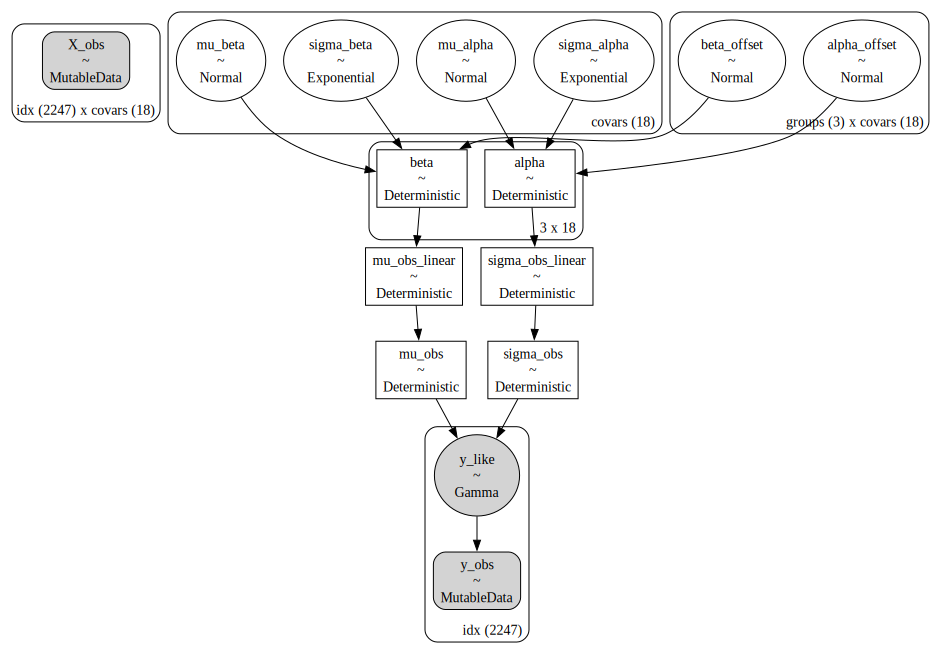

In [217]:
pm.model_to_graphviz(abundance_1)

## Prior predictive checks

In [218]:
with abundance_1:
    prior_samples = pm.sample_prior_predictive(1000)

Sampling: [alpha_offset, beta_offset, mu_alpha, mu_beta, sigma_alpha, sigma_beta, y_like]
INFO:pymc.sampling.forward:Sampling: [alpha_offset, beta_offset, mu_alpha, mu_beta, sigma_alpha, sigma_beta, y_like]


In [212]:
def plot_prior_distribution(category, variable):

    if category == "prior":
        data = prior_samples.prior
    elif category == "prior_predictive":
        data = prior_samples.prior_predictive
    else:
        data = prior_samples.observed_data

    az.plot_dist(
        data[variable],
        figsize=(6, 3),
        kind="hist",
        color="C1",
        hist_kwargs=dict(alpha=0.6, bins=50),
    )

    plt.title(f"{category}: {variable}", fontsize=12)

    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)

    max_ticks = 15
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    plt.xticks(rotation=45)

    plt.show()

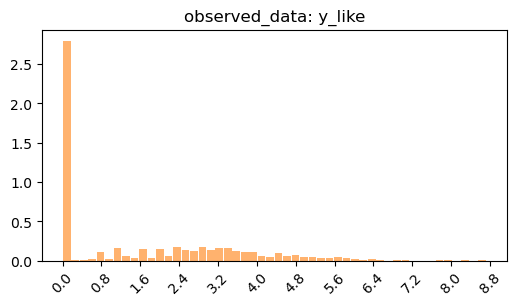

In [213]:
plot_prior_distribution("observed_data", "y_like")

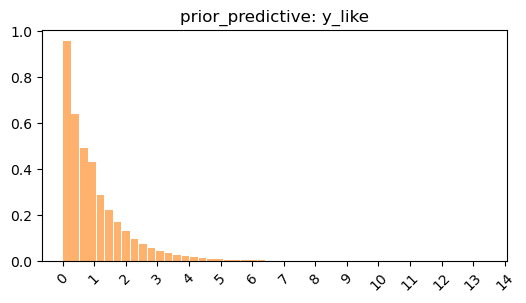

In [219]:
plot_prior_distribution("prior_predictive", "y_like")

In [ ]:
plot_prior_distribution("prior", "mu_beta")

In [ ]:
plot_prior_distribution("prior", "sigma_beta")

In [ ]:
plot_prior_distribution("prior", "beta")

## Sampling and posterior predictive checks

In [41]:
with abundance_1:
    posterior_samples = pm.sample(
        draws=50000,
        tune=100000,
        cores=4,
        chains=4,
        target_accept=0.9,
        nuts_sampler="numpyro",
    )

Compiling...
INFO:pymc.sampling.jax:Compiling...
Compilation time = 0:00:02.126236
INFO:pymc.sampling.jax:Compilation time = 0:00:02.126236
Sampling...
INFO:pymc.sampling.jax:Sampling...


  0%|          | 0/150000 [00:00<?, ?it/s]

  0%|          | 0/150000 [00:00<?, ?it/s]

  0%|          | 0/150000 [00:00<?, ?it/s]

  0%|          | 0/150000 [00:00<?, ?it/s]

Sampling time = 4:52:01.254424
INFO:pymc.sampling.jax:Sampling time = 4:52:01.254424
Transforming variables...
INFO:pymc.sampling.jax:Transforming variables...
Transformation time = 0:00:11.441021
INFO:pymc.sampling.jax:Transformation time = 0:00:11.441021


/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (54), generating only 20 plots
  warnings.warn(


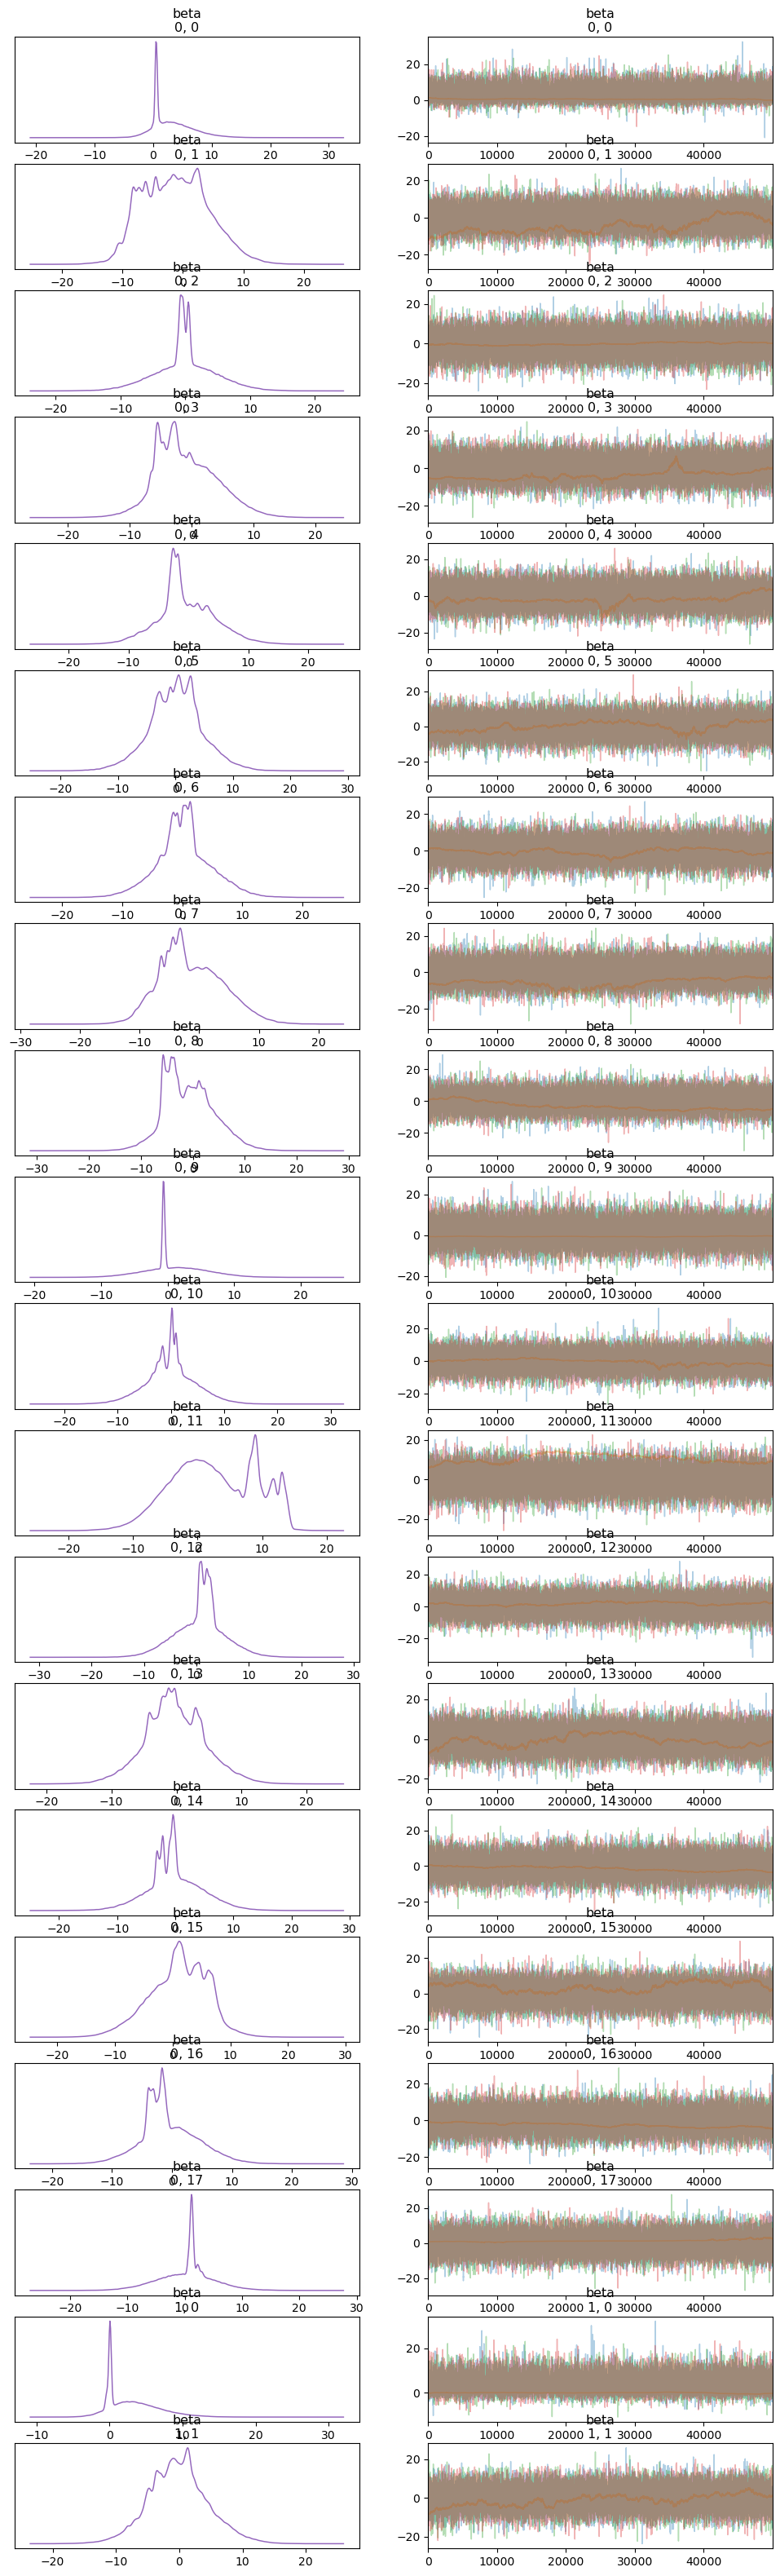

In [42]:
az.plot_trace(
    posterior_samples,
    var_names=["beta"],
    divergences=None,
    compact=False,
    combined=True,
);

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


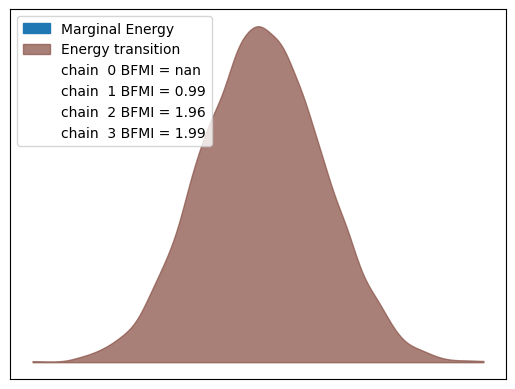

In [223]:
az.plot_energy(posterior_samples);

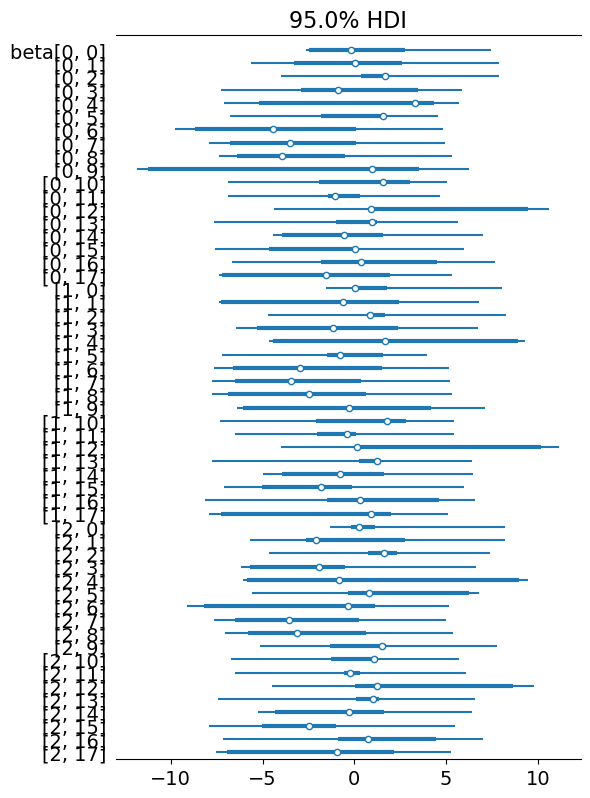

In [224]:
az.plot_forest(posterior_samples, var_names=["beta"], combined=True, hdi_prob=0.95);

In [225]:
az.summary(posterior_samples, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta[Intercept],1.32,2.63,-1.51,6.73,0.91,0.67,6.63,37.85,2.12
mu_beta[Primary vegetation_Light use],-0.49,3.58,-5.64,6.47,1.19,0.87,9.20,41.63,1.73
mu_beta[Primary vegetation_Intense use],1.45,2.44,-3.46,7.03,0.20,0.37,20.18,48.57,2.27
mu_beta[Young secondary vegetation_Minimal use],-0.88,2.98,-6.30,5.28,0.76,0.55,11.84,32.42,1.91
mu_beta[Intermediate secondary vegetation_Minimal use],0.84,5.44,-6.07,7.73,2.41,1.81,5.93,30.59,1.85
...,...,...,...,...,...,...,...,...,...
"alpha[2, 17]",1.49,2.54,-4.46,6.48,0.41,0.36,15.14,32.43,2.11
mu_obs_linear,3000.34,6111.60,-0.23,16223.01,2283.36,1685.29,5.34,23.90,2.05
sigma_obs_linear,3934.96,6039.20,-1024.39,15324.31,2346.09,1737.98,4.80,4.01,2.54
mu_obs,0.73,0.27,0.46,1.00,0.13,0.10,5.21,95.03,2.10


/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (108) in plot_posterior, generating only 40 plots
  warnings.warn(


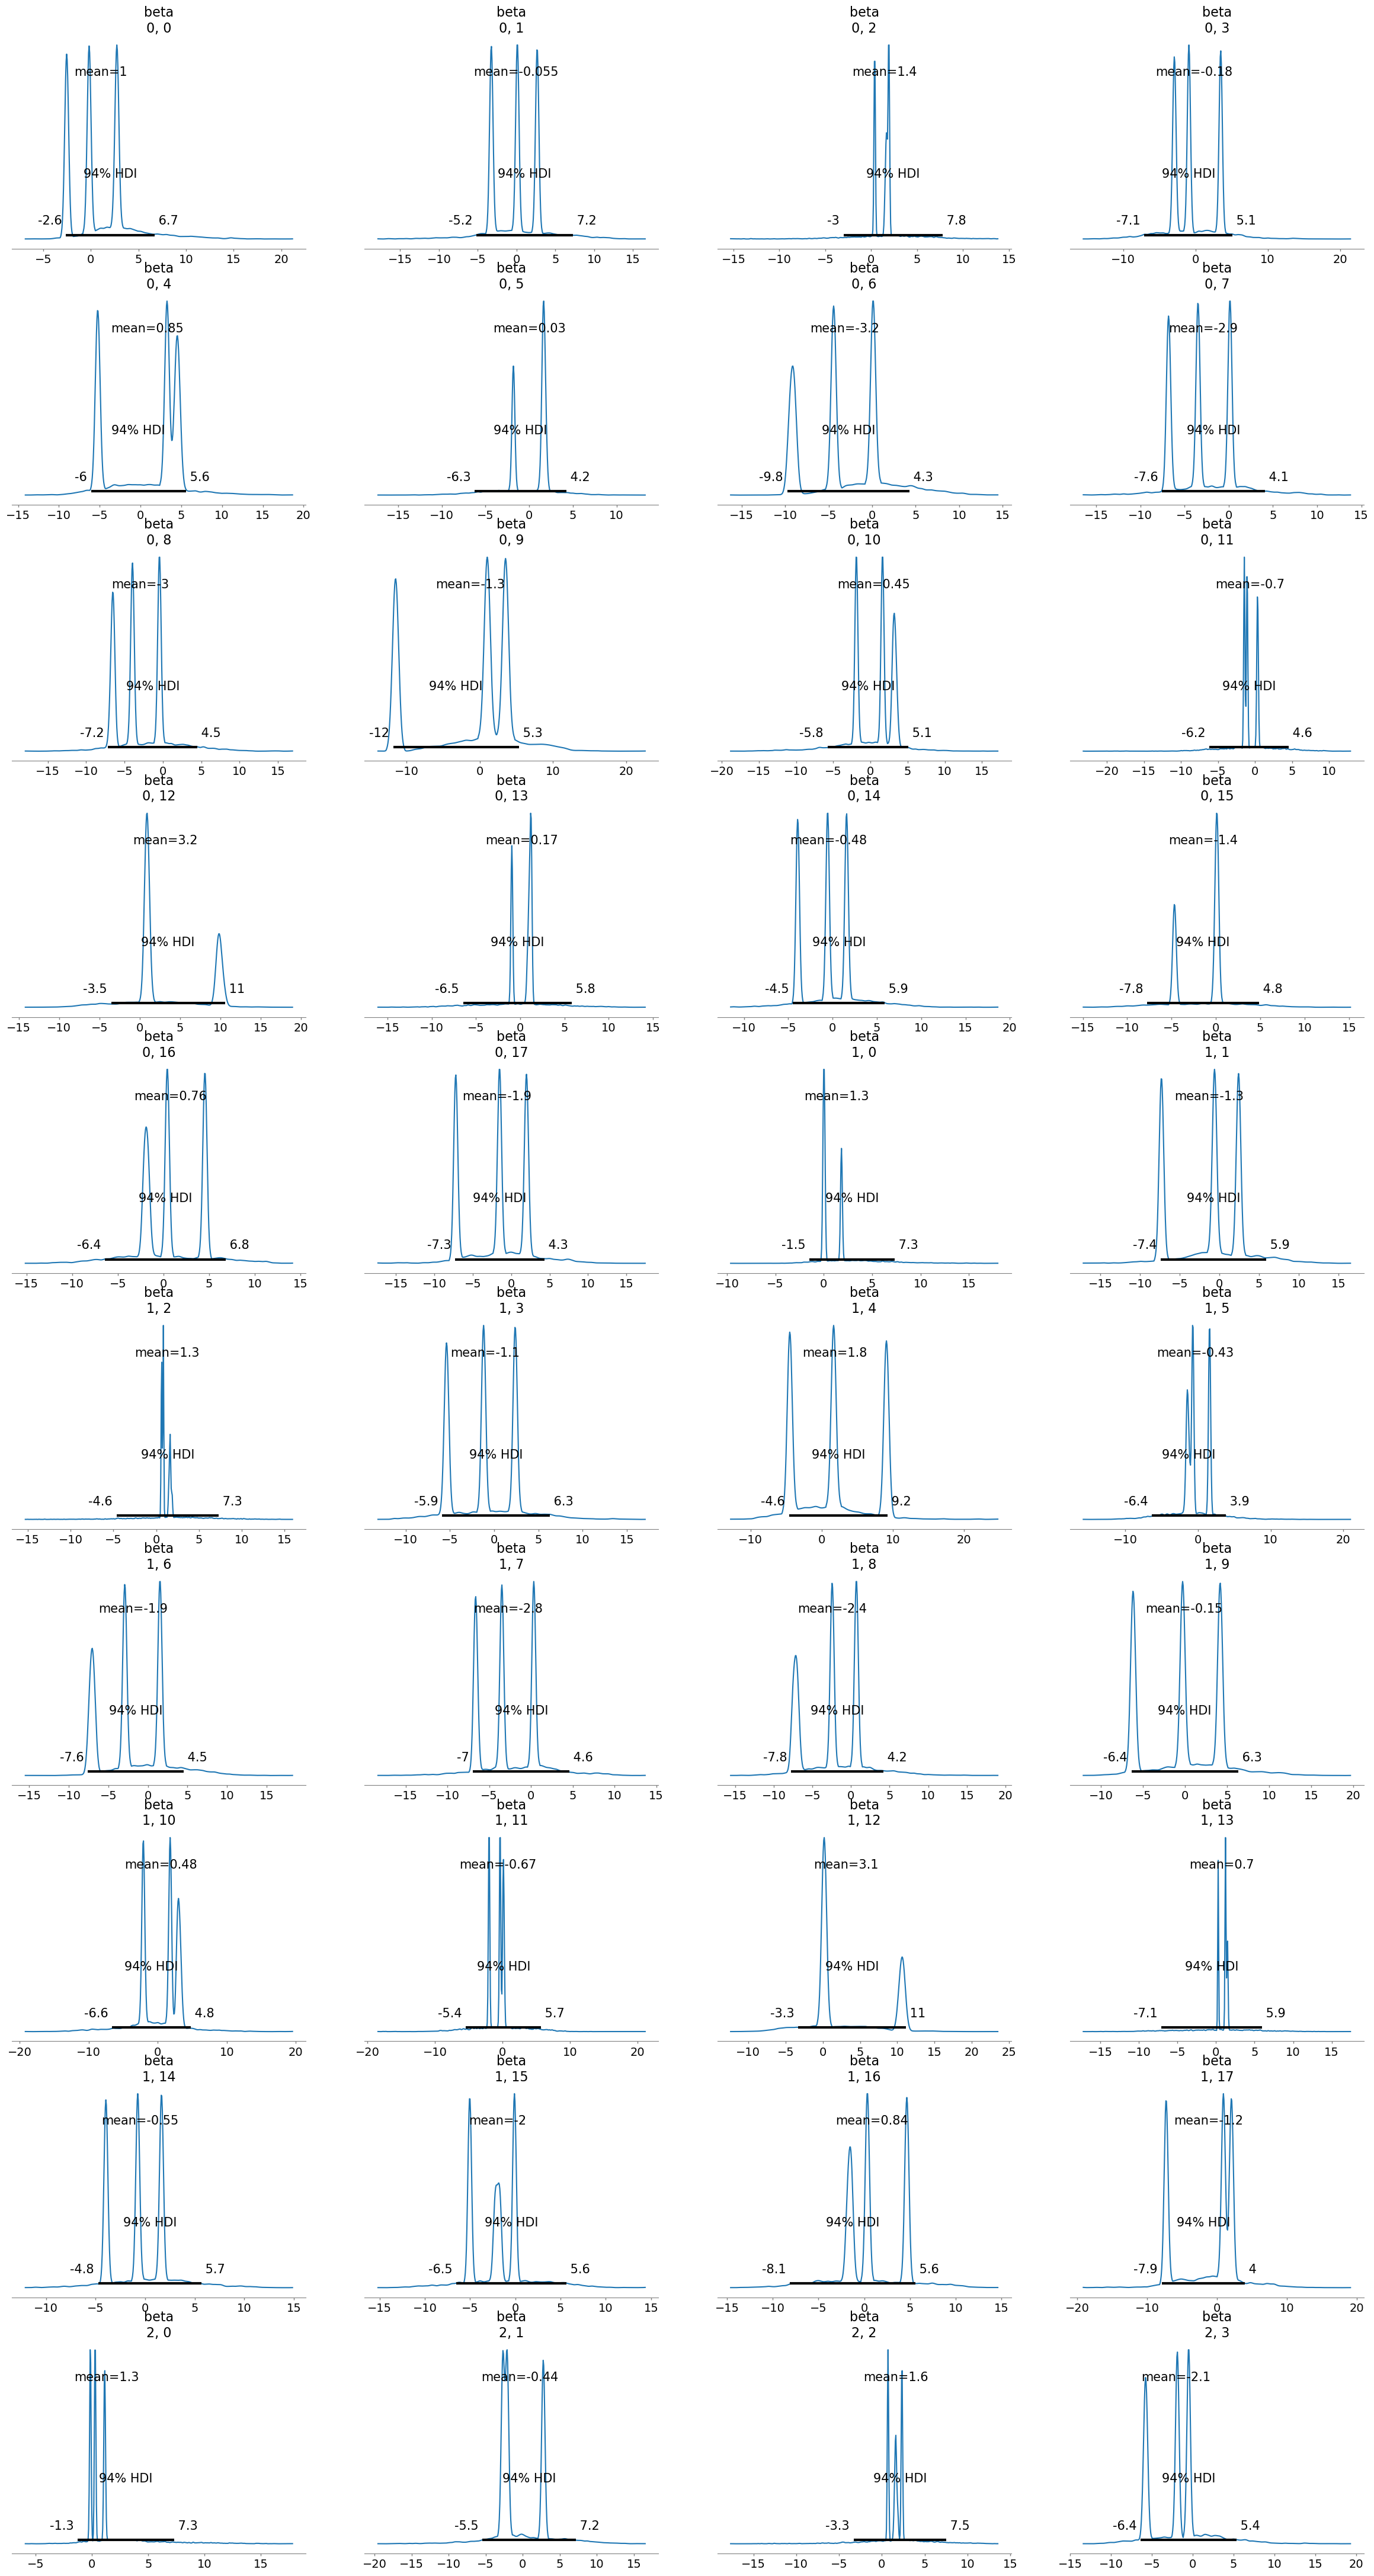

In [226]:
az.plot_posterior(posterior_samples, var_names=["beta", "alpha"]);

In [ ]:
with abundance_1:
    posterior_samples.extend(pm.sample_posterior_predictive(posterior_samples))

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(posterior_samples, ax=ax)
ax.axvline(y.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/essplot.py:205: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = data.dims["draw"]
/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/essplot.py:206: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = n_draws * data.dims["chain"]
/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (54) in plot_ess, generating only 40 pl

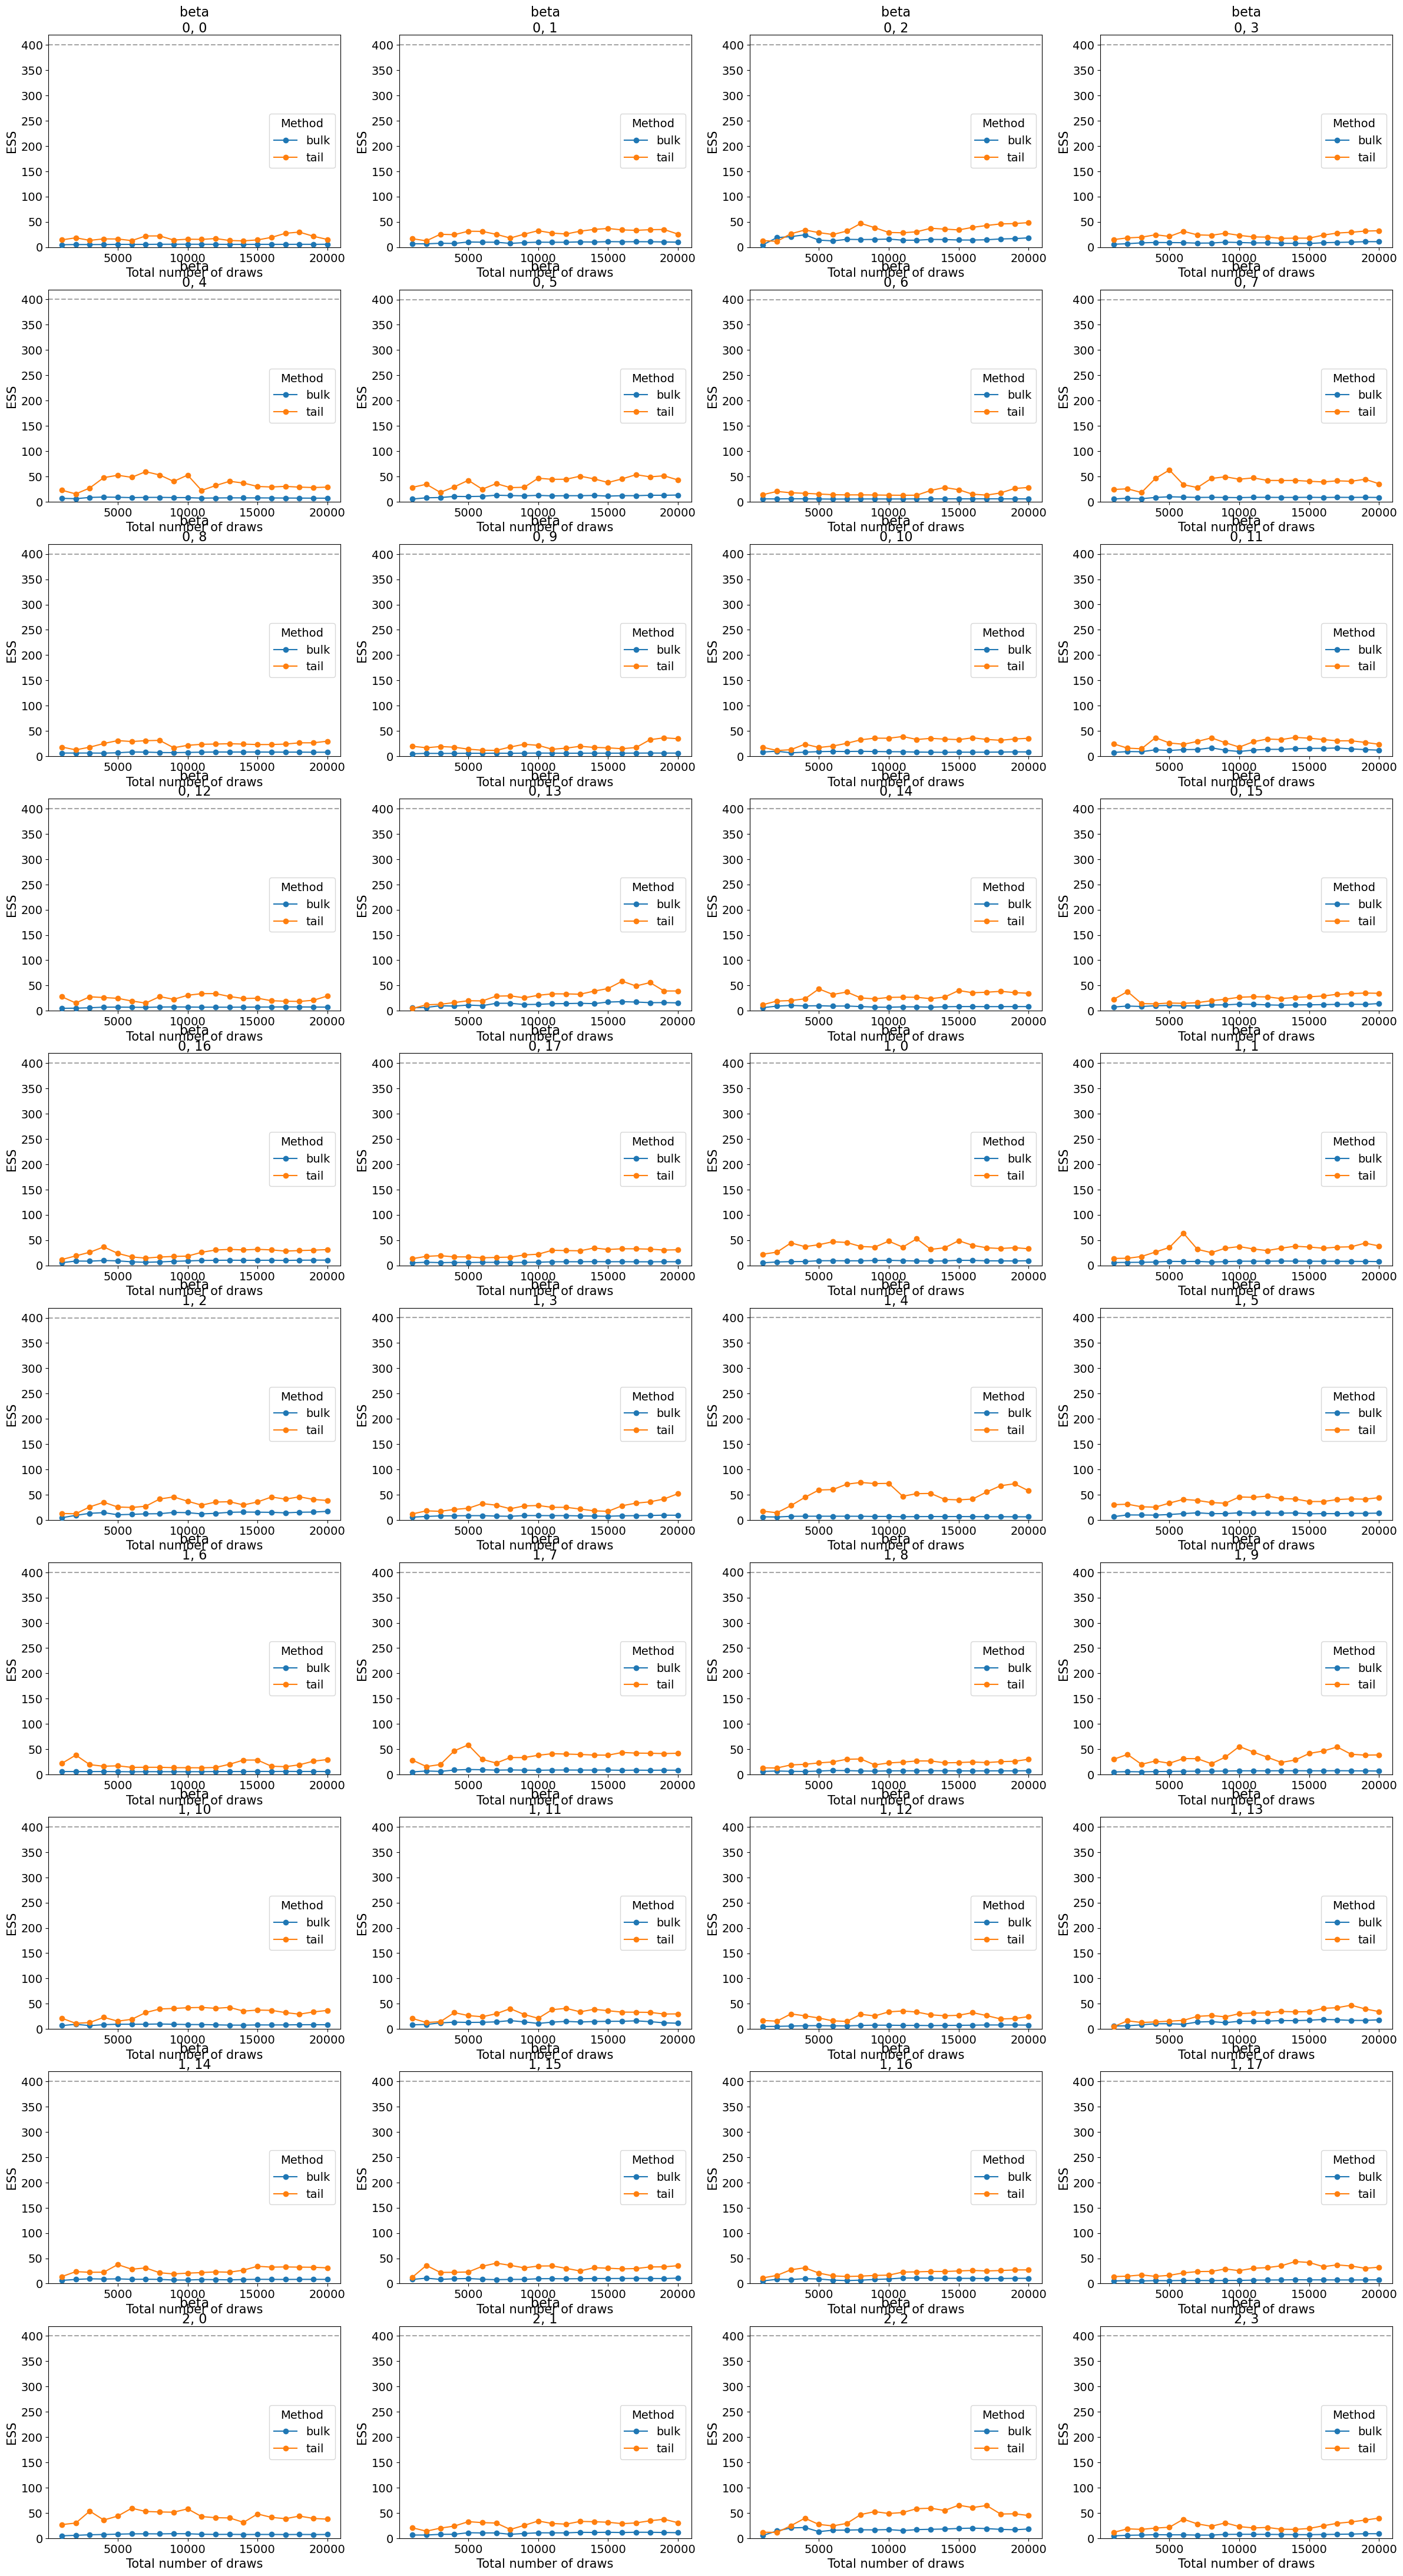

In [230]:
az.plot_ess(posterior_samples, kind="evolution", var_names=["beta"]);

## Train, test and evaluation pipeline

### Evaluation metrics

In [60]:
def symmetric_absolute_mean_percentage_error(
    y_true: np.array, y_pred: np.array, divisor: int = 1
) -> float:
    """
    Function to calculate prediction accuracy, defined as 1 - symmetric mean
    absolute percentage error. (sMAPE). Can either use the "classic" version
    that produces outputs on a scale 0-200% (by using 2 as the divisor) or a
    version on the scale 0-100% (by using 1 instead). More details:
    https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

    Args:
        y_true (np.array): The observed values.
        y_pred (np.array): The corresponding model predictions.
        divisor (int): Number to divide the sum of the prediction and actual
            value with. Defaults to 1.

    Returns:
        The sMAPE value for these two arrays.
    """
    # Check that the divisor argument is valid
    assert divisor in [1, 2], "Divisor argument must be 1 or 2"

    # Perform the accuracy calculation of 1 - sMAPE
    smape = 100 * (
        1
        - np.mean(
            np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)) / divisor)
        )
    )
    return smape

In [61]:
def calculate_bic(log_likelihood: float, nb_obs: int, nb_params: int) -> float:
    """
    Calculates the Bayesian information criterion.

    Args:
        log_likelihood: Log likelihood of data under this model.
        nb_obs: Number of observations in training data.
        nb_params: Number of parameters in model (incl. intercept).

    Returns:
        Calculated BIC score.
    """
    return -2.0 * log_likelihood + np.log(nb_obs) * nb_params

In [62]:
def calculate_aic(log_likelihood: float, nb_obs: int, nb_params: int) -> float:
    """
    Calculates the Akaike information criterion.

    Args:
        log_likelihood: Log likelihood of data under this model.
        nb_obs: Number of observations in training data.
        nb_params: Number of parameters in model (incl. intercept).

    Returns:
        Calculated AIC score.
    """
    return -2.0 * log_likelihood + 2.0 * nb_params

### Evaluation, train and test splits

In [140]:
def create_stratification_column(
    df: pl.DataFrame, stratify_groups: List[str]
) -> pl.DataFrame:

    # Ensure that all group columns are in string format
    for group in stratify_groups:
        df = df.with_columns(pl.col(group).cast(pl.String))

    # If there are multiple groups passed as input, concatenate the string
    # values of the group columns into a single string
    if len(stratify_groups) > 1:
        df = df.with_columns(
            pl.concat_str(groups, separator="_").alias("Stratify_group")
        )
    else:
        df = df.rename(mapping={group: "Stratify_group"})

    # Encode the stratify groups numerically
    # le = LabelEncoder()
    # df = df.to_pandas()  # Need pandas dataframe for this step
    # df["stratify_code"] = le.fit_transform(df["Stratify_group"])
    # df = pl.from_pandas(df)

    return df

In [141]:
df_strat = create_stratification_column(df_dummies, stratify_groups=["Order"])

In [146]:
def stratified_validate_train_test_split(
    df: pl.DataFrame,
    y_var: str,
    X_vars: List[str],
    re_groups: List[str],
    test_size: float = 0.2,
) -> Tuple[pl.DataFrame, pl.DataFrame]:

    # Make a copy of the dataframe, and convert to pandas
    df = df.clone().to_pandas()

    # Perform the split with stratification based on the stratify_groups
    X_train_test, X_validate, y_train_test, y_validate = train_test_split(
        df[X_vars + re_groups + ["Stratify_group"]],
        df[y_var],
        test_size=test_size,
        stratify=df["Stratify_group"],
    )

    # Concatenate into two dataframes, one for train-test and one for validation
    df_train_test = pd.concat(
        [y_train_test, X_train_test], axis="columns", ignore_index=True
    )
    df_validate = pd.concat([y_validate, X_validate], axis="columns", ignore_index=True)

    return pl.from_pandas(df_train_test), pl.from_pandas(df_validate)

In [147]:
df_train_test, df_validate = stratified_validate_train_test_split(
    df_strat,
    y_var="Scaled_abundance",
    X_vars=["Pop_density_1km", "Road_density_50km"],
    re_groups=["SSB"],
    test_size=0.2,
)

In [149]:
df_train_test

0,1,2,3,4
f64,f64,f64,str,str
3.688879,959.141385,5.2822e6,"""MH1_2010__CATI…","""Caudata"""
8.272315,41.255113,2.7888e6,"""MH1_2010__CATI…","""Anura"""
4.26268,39.868943,3.1370e6,"""SC1_2014__Kurz…","""Anura"""
0.0,45.75793,1.7283e6,"""SC1_2014__Kurz…","""Caudata"""
0.0,23.90596,3.4562e6,"""SC1_2006__Urbi…","""Caudata"""
0.0,158.872935,719800.860723,"""MH1_2010__CATI…","""Anura"""
0.0,23.90596,3.4311e6,"""SC1_2006__Urbi…","""Caudata"""
3.310607,48.764471,1.5290e6,"""SC1_2014__Kurz…","""Anura"""
0.0,28.907396,3.6052e6,"""SC1_2006__Urbi…","""Caudata"""


In [144]:
def stratified_kfold(
    df: pl.DataFrame,
    y_var: str,
    X_vars: List[str],
    k: int = 5,
) -> Tuple[List[pl.DataFrame], List[pl.DataFrame], List[pl.Series], List[pl.Series]]:

    # Make a copy of the dataframe
    df = df.clone()

    # Lists for storing the train and test datasets
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    # Set up stratified k-fold sampler object and sample using the
    # stratify code (as the "y class label") for stratification
    skf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, test_index in skf.split(X=df, y=df["Stratify_group"]):
        X_train, X_test = df[train_index, X_vars], df[test_index, X_vars]
        y_train, y_test = df[train_index, y_var], df[test_index, y_var]

        # Store the data for this fold
        X_train_list.append(X_train)
        X_test_list.append(X_test)
        y_train_list.append(y_train)
        y_test_list.append(y_test)

    return X_train_list, X_test_list, y_train_list, y_test_list

In [148]:
X_train_list, X_test_list, y_train_list, y_test_list = stratified_kfold(
    df_train_test,
    y_var="Scaled_abundance",
    X_vars=["Pop_density_1km", "Road_density_50km"],
    k=5,
)

ColumnNotFoundError: Stratify_group

## Variational inference

In [ ]:
with abundance_1:
    vi_posterior = pm.fit()

In [ ]:
vi_samples = vi_posterior.sample(10000)

In [ ]:
az.plot_forest(vi_samples, var_names=["beta"], combined=True, hdi_prob=0.95);

In [ ]:
az.plot_posterior(vi_samples, var_names=["beta", "alpha"]);